In [3]:
%matplotlib inline
import matplotlib.pyplot  as plt
import scipy.fftpack
import numpy  as np
import tensorflow as tf
from tensorflow import keras

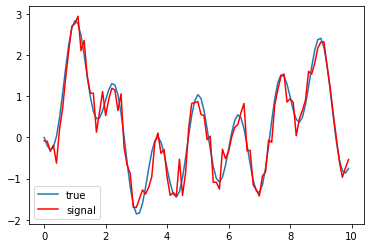

In [5]:
num_train_data = 4000
num_test_data = 1000
timestep = 0.1
tm =  np.arange(0, (num_train_data+num_test_data)*timestep, timestep);
y = np.sin(tm) + np.sin(tm*np.pi/2) + np.sin(tm*(-3*np.pi/2)) 
SNR = 10
ypn = y + np.random.normal(0,10**(-SNR/20),len(y))

plt.plot(tm[0:100],y[0:100], label='true')
plt.plot(tm[0:100],ypn[0:100],'r', label='signal')
plt.legend()

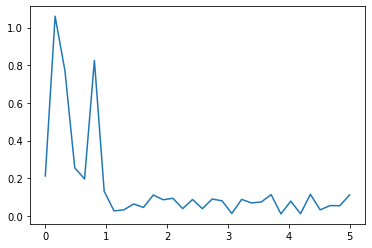

In [6]:
# 64 point FFT
N = 64

# Using the same noisy signal used for LMS
yf = scipy.fftpack.fft(ypn[0:N])

# Let us remove noise, easy to do at the FFT output
#yc = np.zeros(N,dtype=complex)
#cidx = np.where(np.abs(yf)>(N*0.2/2))[0]
#yc[cidx]=yf[cidx]

# 0 to Fs/2, Fs = 1/Ts
xf = np.linspace(0.0, 1.0/(2*timestep), int(N/2))

#fig, ax = plt.subplots()
# Plotting only from 0 to Fs/2
#plt.plot(xf, 2.0/N * np.abs(yc[:N//2]),'r')
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))

In [16]:
# build training data
NFFT = 64
num_train_batch = 1
num_batches = 10000
train_data = np.random.normal(0,1,(num_batches, NFFT*2))
train_labels = np.random.normal(0,1,(num_batches, NFFT*2))

for k in range(num_train_batch):
  for el in range(num_batches):
    fftin = train_data[el,0::2] + 1j*train_data[el,1::2]
    train_labels[el,0::2]=scipy.fftpack.fft(fftin).real
    train_labels[el,1::2]=scipy.fftpack.fft(fftin).imag

In [17]:
def dnn_keras_fft_model():
  model = keras.Sequential([
    keras.layers.Dense(NFFT*2, activation=tf.nn.relu, input_shape=(train_data.shape[1],)),
     keras.layers.Dense(NFFT*2, activation=tf.nn.relu),
    keras.layers.Dense(NFFT*2)
  ])
  optimizer = tf.keras.optimizers.Adam()
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae']) 
  return model

In [18]:
model = dnn_keras_fft_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
Total params: 49,536
Trainable params: 49,536
Non-trainable params: 0
_________________________________________________________________


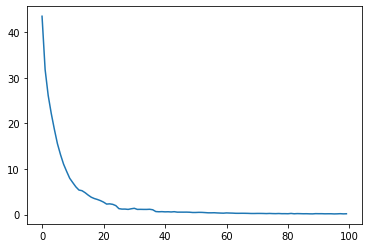

In [19]:
# Train the DNN for 64 point FFT

EPOCHS = 100
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[])
plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')

#  train_data = np.random.normal(0,1,(num_batches, NFFT*2))

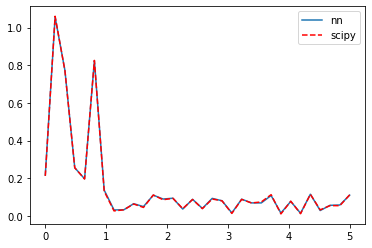

In [26]:
fftin = np.zeros((1,2*NFFT))
fftin[:,0::2]=ypn[0:NFFT]
fftout = model.predict(fftin).flatten()
fftout = fftout[0::2] + 1j*fftout[1::2]
plt.plot(xf, 2.0/NFFT * np.abs(fftout[0:NFFT//2]), label="nn")
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]),'r--', label="scipy")
plt.legend()